# De et al 2025
# Simulating inference results in the 8-parameter model

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pickle
from wf import combined_WF
import matplotlib
import seaborn as sns
from seaborn import pairplot
from collective_posterior_de import CollectivePosterior
from matplotlib.pyplot import Line2D

# for making larger graphs
def change_font(fontsize):
    matplotlib.rcParams['xtick.labelsize'] = fontsize
    matplotlib.rcParams['ytick.labelsize'] = fontsize
    matplotlib.rcParams['font.size'] = fontsize

In [3]:
# load posteriors, prior, data, etc.
posterior = pickle.load(open('results/posterior_de_3p_10000_noisy.pkl','rb'))
prior = posterior.prior
data = pd.read_csv('empirical_data/clean_data_exp_2.csv')

# Filter contaminated replicate
clean_data = data.drop(data[data['Strain']=='DGY2751_1'].index)

# Prep
num_lines = len(data['Line'].unique())
num_strains_max = 4 # max strains per line
generation = np.array(data[data['Strain'] == 'DGY1886_1']['Generation'])

# Match color palettes
colors_mep = ['peru', 'orange', 'brown', 'orangered', 'sienna']
colors_gap = ['royalblue', 'limegreen', 'green', 'darkturquoise', 'steelblue']
color_g = 'steelblue'
color_m = 'sienna'
# Match strain names
line_mapping = {'DGY1886': 'G_4', 'DGY2748': 'GM_12', 'DGY2750': 'GM_13', 'DGY2751':'GM_14', 'DGY2755':'GM_15'}

In [4]:
# posterior predictive checks - plot posterior samples against empirical data
def plot_ppc(ax, posterior, strain, df, generation=generation, color='darksalmon', t = 1):
    # inference for both trajectories
    x_0, x_1 = np.array(df[df['Strain']==strain][['Multicopy_mCitrine ']]), np.array(df[df['Strain']==strain][['Multicopy_mCherry']])
    samples_0 = posterior.set_default_x(x_0.reshape((1,-1))).sample((100,)) # sample from posterior of strain
    samples_1 = posterior.set_default_x(x_1.reshape((1,-1))).sample((100,)) # sample from posterior of strain
    s_cc = torch.log10((1+10**samples_0[:,0])*(1+10**samples_1[:,0])-1)
    p0_cc = samples_0[:,2] + samples_1[:,2]
    
    # plot WF(posterior samples)
    if t==1:
        y = x_1
        l = len(generation)
    else:
        y = x_0
        l = 0
    for i in range(len(samples_0)):
        # get additional porameters for sample i
        s_cherry, m_cherry, p0_cherry, s_citrine, m_citrine, p0_citrine, s_c, p0_c = samples_0[i,0].item(), samples_0[i,1].item(), samples_0[i,2].item(), samples_1[i,0], samples_1[i,1].item(), samples_1[i,2].item(), s_cc[i].item(), p0_cc[i].item() 
        simulation = combined_WF(s_cherry, m_cherry, p0_cherry, s_citrine, m_citrine, p0_citrine, s_c, p0_c, generation)
        ax.plot(generation, simulation[l:l+len(generation)], color=color, ls='--', label='prediction', lw=40/len(samples_0))
    
    # empirical data
    ax.plot(generation, y, color=color, label='data', lw=4.5) # plot for reference
    ax.scatter(generation, y, color=color, label='data', s=60) # plot for reference
    return s_cc

def plot_collective_ppc(ax, posterior, line, epsilon, color, colors, n_samples=1000, t=0):
    X_0, X_1 = clean_data[clean_data['Line'] == line]['Multicopy_mCitrine '], clean_data[clean_data['Line'] == line]['Multicopy_mCherry']
    X_0, X_1 = torch.from_numpy(np.array(X_0).reshape(len(X_0)//len(generation), len(generation))), torch.from_numpy(np.array(X_1).reshape(len(X_1)//len(generation), len(generation)))
    cp_0 = CollectivePosterior(posterior.prior,X_0,posterior, epsilon=epsilon)
    cp_0.get_log_C()
    samples_0 = cp_0.rejection_sample(n_samples)
    cp_1 = CollectivePosterior(posterior.prior,X_1,posterior, epsilon=epsilon)
    cp_1.get_log_C()
    samples_1 = cp_1.rejection_sample(n_samples)
    s_cc = torch.log10((1+10**samples_0[:,0])*(1+10**samples_1[:,0])-1)
    p0_cc = samples_0[:,2] + samples_1[:,2]

    if t==1:
        y = X_1
        l = len(generation)
        color = 'sienna'
    else:
        y = X_0
        l = 0
        color = 'steelblue'
    for i in range(len(samples_0)):
        s_cherry, m_cherry, p0_cherry, s_citrine, m_citrine, p0_citrine, s_c, p0_c = samples_0[i,0].item(), samples_0[i,1].item(), samples_0[i,2].item(), samples_1[i,0], samples_1[i,1].item(), samples_1[i,2].item(), s_cc[i].item(), p0_cc[i].item() 
        simulation = combined_WF(s_cherry, m_cherry, p0_cherry, s_citrine, m_citrine, p0_citrine, s_c, p0_c, generation)
        ax.plot(generation, simulation[l:l+len(generation)], color=color, ls='--', label='prediction', lw=40/len(samples_0))
    # empirical data
    for j in range(len(y)):
        ax.plot(generation, y[j,:], color=colors[j], label='data', lw=4.5) # plot for reference
        ax.scatter(generation, y[j,:], color=colors[j], label='data', s=60) # plot for reference
    ax.set_facecolor('whitesmoke')
    return s_cc

Rejection Sampling: 1153it [00:00, 3029.47it/s]                         
Rejection Sampling: 1146it [00:00, 1684.95it/s]                         
Rejection Sampling: 1125it [00:00, 3400.65it/s]                         
Rejection Sampling: 1100it [00:00, 1611.13it/s]                         


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/home/jupyter-nadavbennun/Nadav/De et al/de_et_al/collective_posterior_de.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
Rejection Sampling: 1959it [00:00, 18202.61it/s]            
Rejection Sampling: 1293it [00:00, 5997.57it/s]                         
Rejection Sampling: 1860it [00:00, 15275.34it/s]            
Rejection Sampling: 1316it [00:00, 5178.86it/s]                         


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/home/jupyter-nadavbennun/Nadav/De et al/de_et_al/collective_posterior_de.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
Rejection Sampling: 1053it [00:00, 1275.02it/s]                         
Rejection Sampling: 1347it [00:00, 2447.88it/s]                         
Rejection Sampling: 1126it [00:00, 1343.00it/s]                         
Rejection Sampling: 1263it [00:00, 2266.07it/s]                         


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/home/jupyter-nadavbennun/Nadav/De et al/de_et_al/collective_posterior_de.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
Rejection Sampling: 1034it [00:00, 3332.43it/s]             
Rejection Sampling: 1090it [00:01, 818.74it/s]                         
Rejection Sampling: 1909it [00:00, 4681.24it/s]                         
Rejection Sampling: 1106it [00:00, 1359.93it/s]                         


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

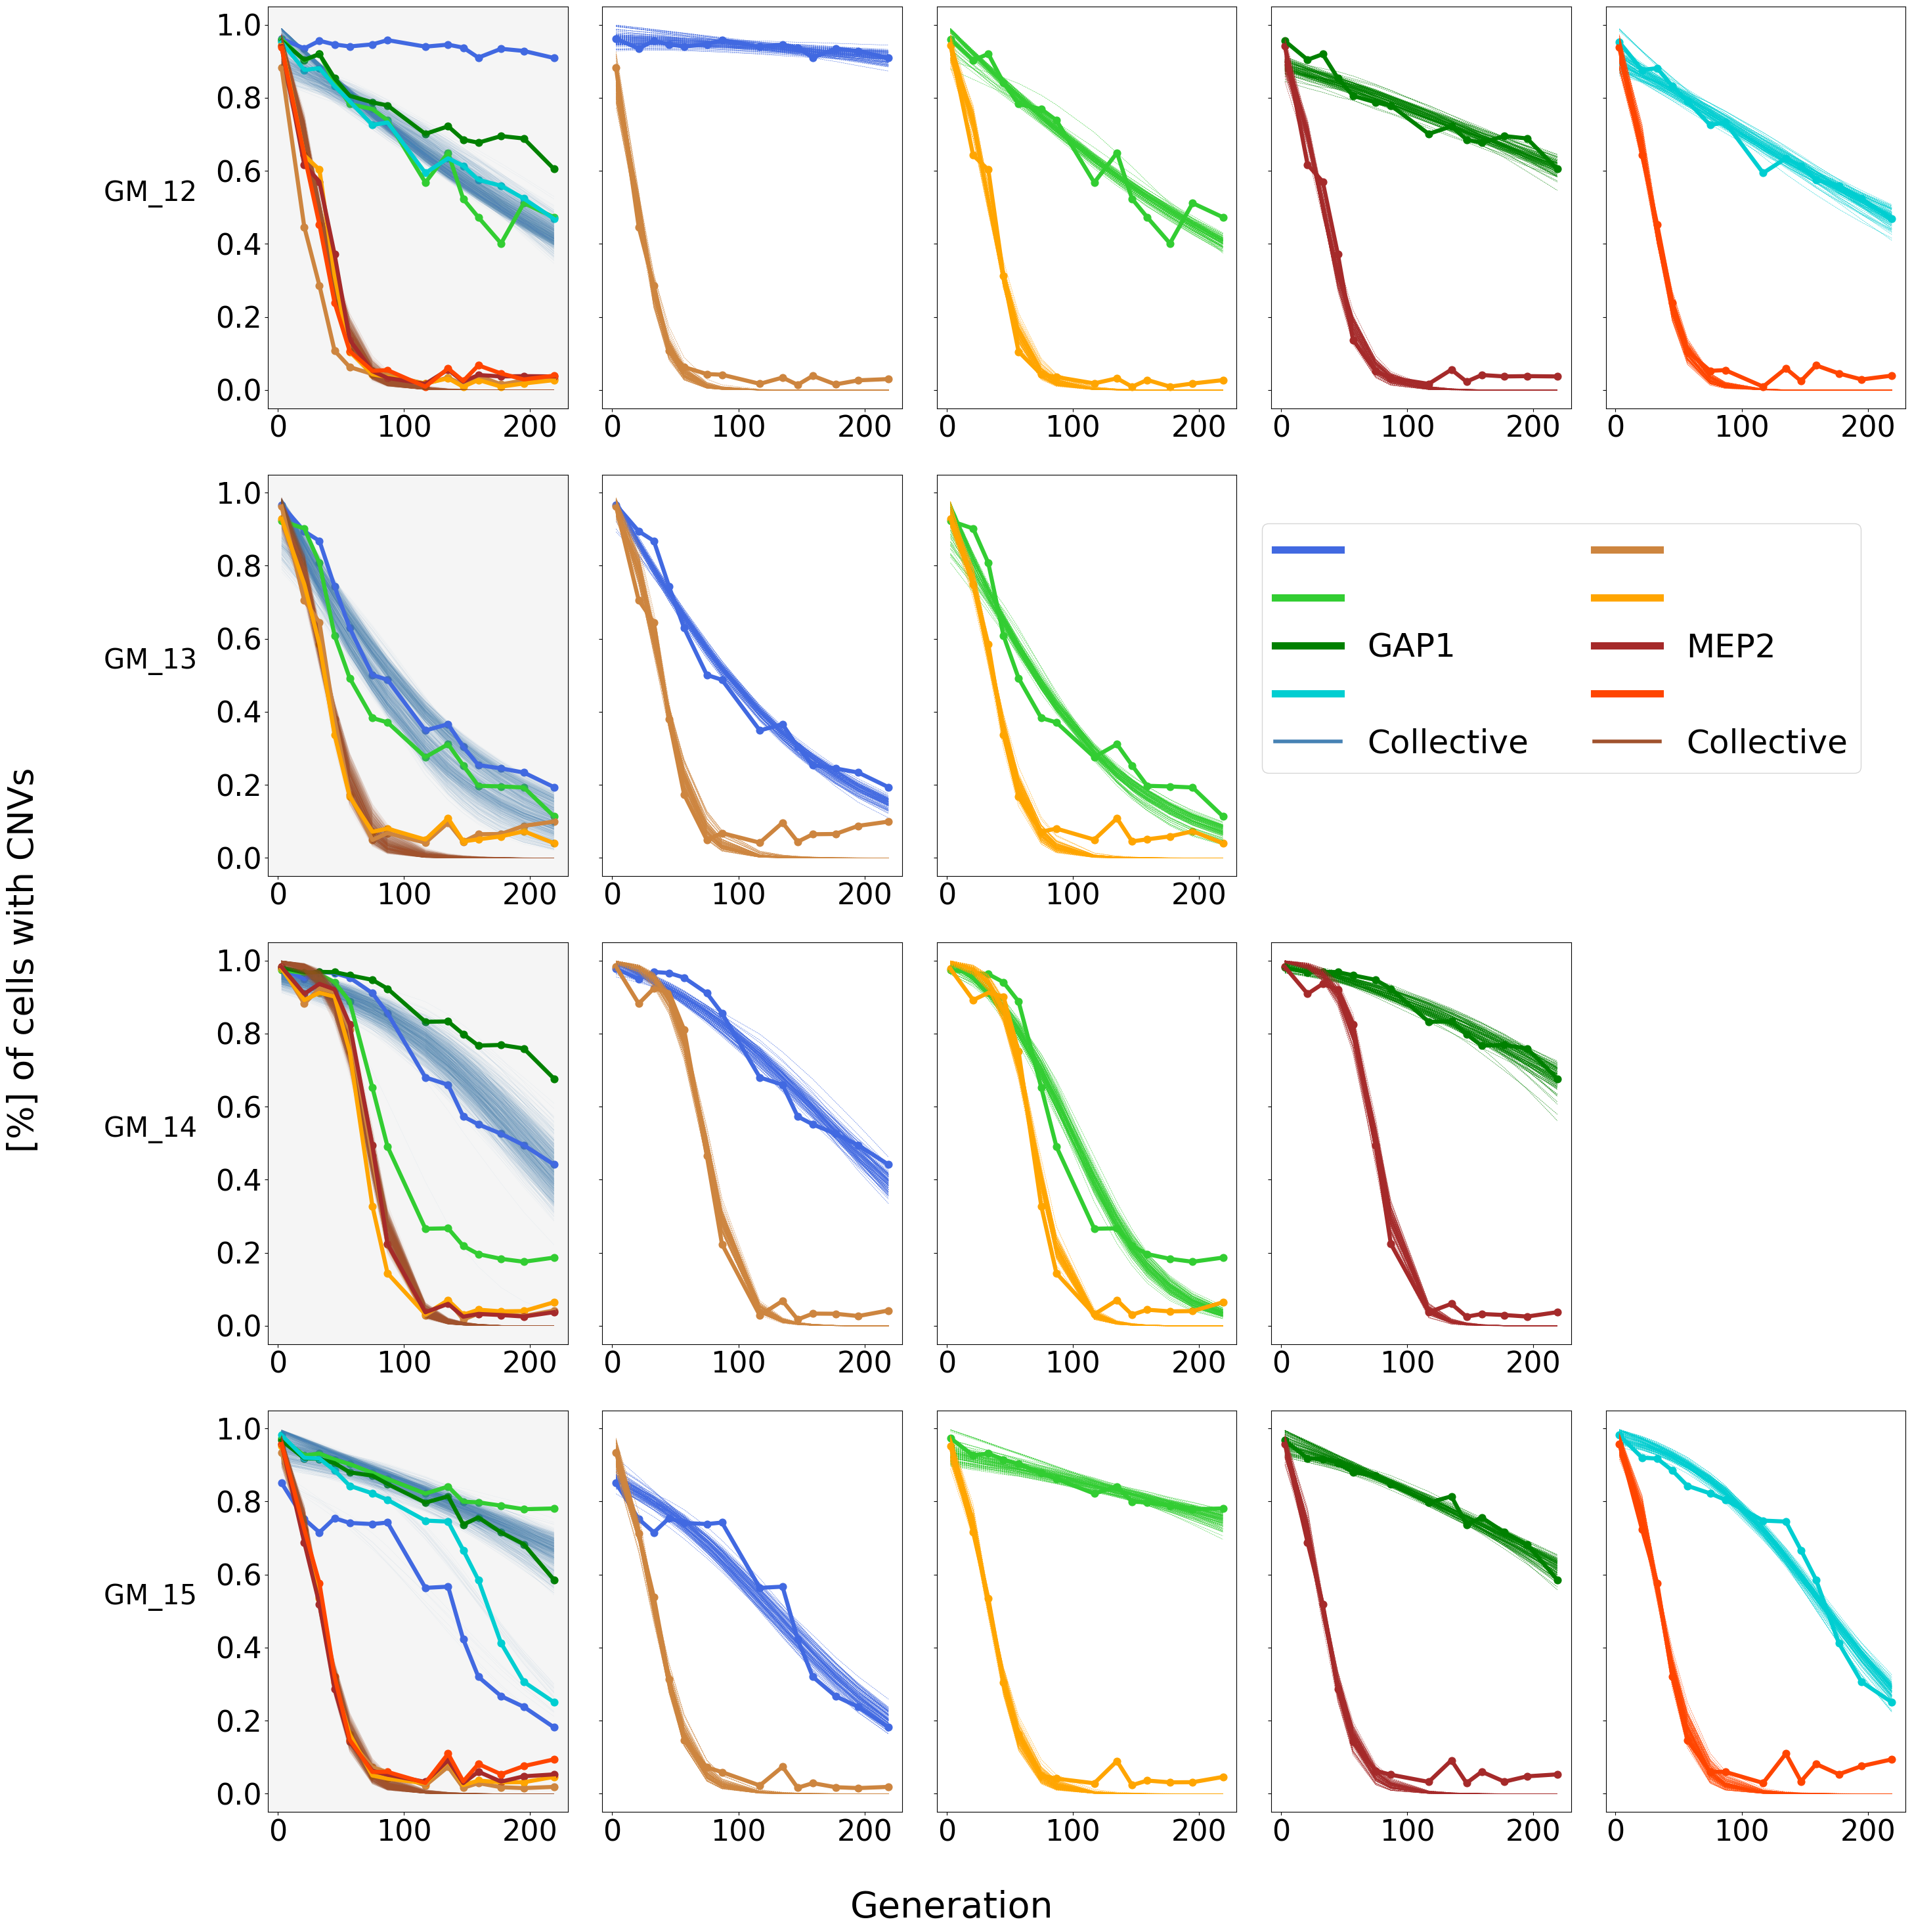

In [6]:
# large fonts for paper
change_font(32)

# create a single figure for all lines - X is generation, Y is cnv proportion
lines = clean_data['Line'].unique()
fig, ax = plt.subplots(len(lines)-1, num_strains_max+1, figsize=(30,30), tight_layout=True, sharey=True)
fig.supxlabel('Generation', fontsize=40)
fig.supylabel('[%] of cells with CNVs\n')

colors = ['darksalmon', 'cornflowerblue', 'turquoise', 'goldenrod', 'tan'] # unique color per line
epsilons = [-30,-30,-30,-60,-30]

# ax[i,j] will show predictive checks for the i'th line's j'th replicate
f = []
for i in range(1,len(lines)):
    dd = clean_data[clean_data['Line']==lines[i]] # data for line i
    local_strains = dd['Strain'].unique() # strains of line i
    f.append(plot_collective_ppc(ax=ax[i-1,0], posterior=posterior, line=lines[i], epsilon=epsilons[i], color=colors_gap,colors=colors_gap, t=0))
    f.append(plot_collective_ppc(ax=ax[i-1,0], posterior=posterior, line=lines[i], epsilon=epsilons[i], color=colors_mep,colors=colors_mep, t=1))
    ax[i-1,0].set_ylabel(line_mapping[lines[i]]+' '*14, fontsize=30, rotation='horizontal')
    for j in range(len(local_strains)):
        plot_ppc(ax[i-1,j+1], posterior, local_strains[j], dd, color=colors_gap[j], t=0)
        plot_ppc(ax[i-1,j+1], posterior, local_strains[j], dd, color=colors_mep[j], t=1)
    if len(local_strains) < num_strains_max:
        for k in range(len(local_strains),num_strains_max):
            ax[i-1,k+1].set_axis_off()

# Legend
legend_elements = []
for i in range(len(colors_gap)-1):
    legend_elements.append(Line2D([0], [0], color=colors_gap[i], lw=8, label='GAP1' if i==2 else ''))
legend_elements.append(Line2D([0], [0], color=colors_gap[-1], lw=4, label='Collective'))
for j in range(len(colors_mep)-1):
    legend_elements.append(Line2D([0], [0], color=colors_mep[j], lw=8, label='MEP2' if j==2 else ''))
legend_elements.append(Line2D([0], [0], color=colors_mep[-1], lw=4, label='Collective'))   

fig.legend(loc=(0.66,0.6), ncol=2, handles=legend_elements, fontsize=36)

fig.savefig('S7.pdf', dpi=600)